# Timm models on multicore TPUs using fastai_xla_extensions with albumentations

> A sample notebook on using Wright Rossman's Pytorch Image Models plus Albumentations (for data augmentation) on multi core TPUs using fastai_xla_extensions.

Assumptions:
 * python 3.7 install (Colab Default)

Install torch 1.7.1

In [1]:
!pip install -qqq --no-cache-dir torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchtext==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

     |████████████████████████████████| 735.4MB 1.1MB/s 
     |████████████████████████████████| 12.8MB 38.5MB/s 
     |████████████████████████████████| 7.0MB 4.4MB/s 


Install torch-xla 1.7

In [2]:
!pip install -Uqq cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp37-cp37m-linux_x86_64.whl

     |████████████████████████████████| 133.6MB 29kB/s 
     |████████████████████████████████| 61kB 3.7MB/s 
ERROR: earthengine-api 0.1.260 has requirement google-api-python-client<2,>=1.12.1, but you'll have google-api-python-client 1.8.0 which is incompatible.


Install fastai  

In [3]:
!pip install -Uqq fastai --upgrade

     |████████████████████████████████| 194kB 7.1MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 


Install timm, wwf (walk with fastai) and albumentations packages as well as my utils library.

* timm - Wright Rossmann's pytorch image models library
* wwf - Zach Mueller's walk with fastai library (containing convenience functions to work with the timm package)
* albumentations - data augmentations
* my_timesaver_utils - various bits of reusable code I've found useful.

In [4]:
!pip install -Uqq timm

     |████████████████████████████████| 296kB 5.4MB/s 


In [5]:
!pip install -Uqq wwf

In [6]:
!pip install -Uqq albumentations

     |████████████████████████████████| 81kB 4.3MB/s 
     |████████████████████████████████| 37.6MB 125kB/s 
     |████████████████████████████████| 952kB 61.7MB/s 


Install fastai_xla_extensions

In [7]:
!pip install -Uqq fastai_xla_extensions

In [8]:
!pip install -Uqq git+https://github.com/butchland/my_timesaver_utils.git

(Optional) Link fastai data and model dirs to content dir

In [9]:
!curl -s https://course19.fast.ai/setup/colab | bash

Updating fastai...
Done.


Document package versions

In [10]:
!pip freeze | grep torch
!pip freeze | grep fast
!pip freeze | grep timm
!pip freeze | grep wwf
!pip freeze | grep albumentations
!pip freeze | grep timesaver

torch==1.7.1+cu101
torch-xla==1.7
torchsummary==1.5.1
torchtext==0.8.0
torchvision==0.8.2+cu101
fastai==2.3.0
fastai-xla-extensions==0.0.11
fastcore==1.3.19
fastdtw==0.3.4
fastprogress==1.0.0
fastrlock==0.6
timm==0.4.5
wwf==0.0.14
albumentations==0.5.2
my-timesaver-utils==0.0.2


Start of code

In [11]:
from fastai.vision.all import *
from fastai_xla_extensions.all import *

In [12]:
from my_timesaver_utils.misc_splitters import *

In [13]:
from wwf.vision.timm import *

In [14]:
import albumentations

Provide Albumentations fastai transforms adapter
_copied from [Zach Mueller's kaggle sample notebook](https://www.kaggle.com/muellerzr/recreating-abhishek-s-tez-with-fastai?rvi=1&scriptVersionId=47936294&cellId=10)_ 

In [15]:
class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [16]:
def get_train_aug(sz): return albumentations.Compose([
            albumentations.Resize(int(sz*1.2),int(sz*1.2)),
            albumentations.RandomResizedCrop(sz,sz),
            albumentations.Transpose(p=0.5),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
            albumentations.CoarseDropout(p=0.5),
            albumentations.Cutout(p=0.5)
])

def get_valid_aug(sz): return albumentations.Compose([
    albumentations.Resize(int(sz*1.2),int(sz*1.2)),
    albumentations.CenterCrop(sz,sz, p=1.),
    albumentations.Resize(sz,sz)
], p=1.)

In [17]:
path = untar_data(URLs.PETS)/'images'

In [18]:
pat = r'(.+)_\d+.jpg$'

In [19]:
bs = 64
sz = 128
train_pct=0.9

In [20]:
item_tfms =  [AlbumentationsTransform(get_train_aug(sz), get_valid_aug(sz)),]

In [21]:
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=using_attr(RegexLabeller(pat),'name'),
    splitter=SubsetPercentageSplitter(RandomSplitter(seed=42), train_pct=train_pct),
    item_tfms=item_tfms,
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5320,1330
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_44.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x333
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_44.jpg
    applying partial gives
      Maine_Coon
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(6)

Final sample: (PILImage mode=RGB size=500x333, TensorCategory(6))


Found 7390 items
2 datasets of sizes 5320,1330
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: 

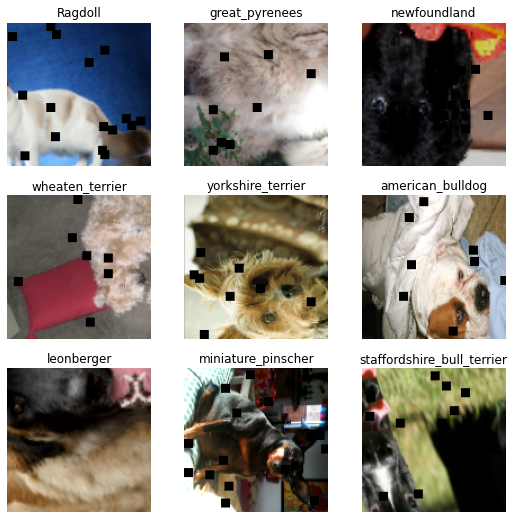

In [22]:
data.summary(path, bs=bs//4, show_batch=True)

In [23]:
dls = data.dataloaders(path, bs=bs)

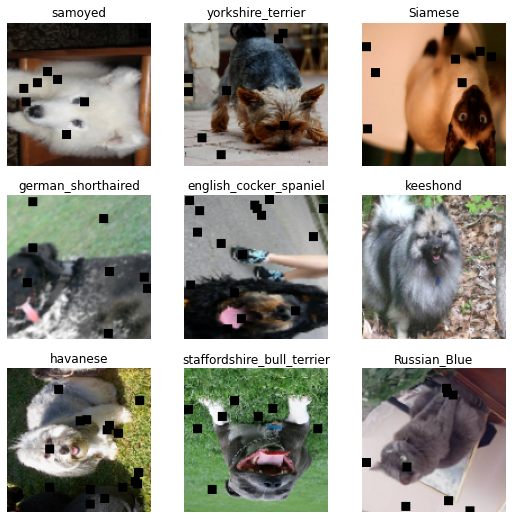

In [24]:
dls.show_batch()

In [25]:
# learn = timm_learner(dls, 'resnext50_32x4d', metrics=accuracy, 
#                      opt_func=Adam, loss_func=CrossEntropyLossFlat(),
#                      config={'concat_pool':False})
learn = timm_learner(dls, 'seresnext50_32x4d', metrics=accuracy, 
                     opt_func=ranger, loss_func=LabelSmoothingCrossEntropy(),
                     config={'concat_pool':False})

# learn = timm_learner(dls, 
#                     'tf_efficientnet_b5_ns',
#                      opt_func=ranger,
#                      loss_func=LabelSmoothingCrossEntropy(),
#                      config={'concat_pool':False},
#                      cbs=[GradientAccumulation(n_acc=32)],
#                      metrics=accuracy)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/seresnext50_32x4d_racm-a304a460.pth" to /root/.cache/torch/hub/checkpoints/seresnext50_32x4d_racm-a304a460.pth


In [26]:
# learn.to_xla()

start fit


CPU times: user 1.01 s, sys: 243 ms, total: 1.25 s
Wall time: 3min 32s


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=3.311311274956097e-06)

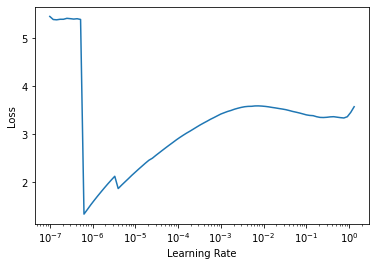

In [27]:
%%time
learn.xla_lr_find()
# learn.fit(1,lr=1e-3)
# learn.xla_fit(1, lr=1e-2)

In [28]:
# print_aten_ops()


In [29]:
# learn.summary()

In [30]:
%%time
learn.xla_fit_one_cycle(3,lr_max=slice(1e-2))

start fit


epoch,train_loss,valid_loss,accuracy,time
0,1.195103,3.077062,0.266467,01:36
1,1.529681,1.984796,0.657934,00:16
2,1.883564,1.749942,0.675150,00:15


CPU times: user 1.51 s, sys: 446 ms, total: 1.95 s
Wall time: 2min 20s


In [31]:
learn.unfreeze()

start fit


CPU times: user 1.26 s, sys: 257 ms, total: 1.52 s
Wall time: 4min 36s


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=3.311311274956097e-06)

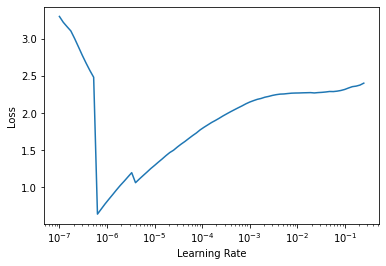

In [32]:
%%time
learn.xla_lr_find()

In [33]:
learn.save('stage-1')

Path('models/stage-1.pth')

In [34]:
learn.xla_fit_one_cycle(5, lr_max=slice(1e-5,5e-3))

start fit


epoch,train_loss,valid_loss,accuracy,time
0,0.565700,1.684818,0.675150,02:38
1,0.769898,1.605164,0.689371,00:16
2,1.190474,1.536310,0.723802,00:16
3,1.536234,1.512415,0.731287,00:16
4,1.812689,1.508942,0.730539,00:16


In [35]:
learn.save('stage-2')

Path('models/stage-2.pth')

In [36]:
def make_dblock(sz, pct=1.0):
    item_tfms =  [AlbumentationsTransform(get_train_aug(sz), get_valid_aug(sz)),]
    data = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        get_y=using_attr(RegexLabeller(pat),'name'),
        splitter=SubsetPercentageSplitter(RandomSplitter(seed=42), train_pct=pct),
        item_tfms=item_tfms,
        batch_tfms=[Normalize.from_stats(*imagenet_stats)]
    )
    return data

In [37]:
def make_dls(data, bs=64):
    dls = data.dataloaders(path, bs=bs)
    return dls

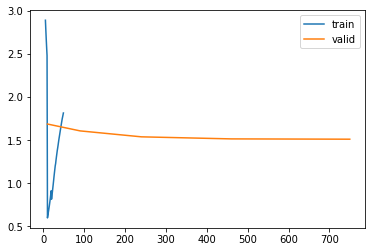

In [38]:
learn.recorder.plot_loss()

In [39]:
data2 = make_dblock(224)
dls2 = make_dls(data2)

In [40]:
learn = timm_learner(dls2, 'seresnext50_32x4d', metrics=accuracy, 
                     opt_func=ranger, loss_func=LabelSmoothingCrossEntropy(),
                     config={'concat_pool':False})

In [41]:
# learn.dls = dls2

In [42]:
learn.load('stage-2')

In [43]:
learn.freeze()

start fit


CPU times: user 1.69 s, sys: 330 ms, total: 2.02 s
Wall time: 6min 30s


SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=6.309573450380412e-07)

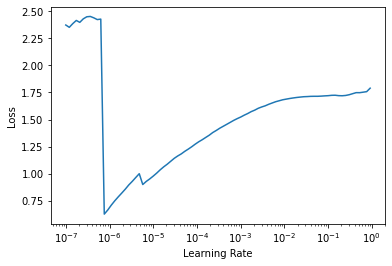

In [44]:
%%time
learn.xla_lr_find()

In [45]:
%%time
learn.xla_fit_one_cycle(5, lr_max=slice(5e-2))

start fit


epoch,train_loss,valid_loss,accuracy,time
0,0.570906,1.216579,0.868919,02:12
1,0.798585,1.338812,0.874324,00:47
2,1.013633,1.216087,0.872297,00:39
3,1.154641,1.103714,0.891216,00:43
4,1.259049,1.084347,0.895270,00:40


CPU times: user 2.19 s, sys: 593 ms, total: 2.78 s
Wall time: 5min 19s


In [46]:
learn.save('stage-3')

Path('models/stage-3.pth')

In [47]:
learn.unfreeze()

In [48]:
%%time
learn.xla_fit_one_cycle(10, lr_max=slice(1e-5,5e-3), master_cbs=[SaveModelCallback(monitor='accuracy',comp=np.greater, fname='best_model')])

start fit


epoch,train_loss,valid_loss,accuracy,time
0,0.293118,1.092081,0.891892,03:05
1,0.383145,1.040921,0.898649,01:19
2,0.483427,1.034196,0.901351,00:41
3,0.626225,1.035821,0.893243,00:38
4,0.820487,1.035026,0.902027,00:39
5,0.972584,1.027592,0.902703,00:42
6,1.102010,1.026423,0.900676,00:30
7,1.192703,1.014716,0.904054,00:38
8,1.254905,1.011105,0.904730,00:41
9,1.310113,1.008917,0.903378,00:42


Better model found at epoch 0 with accuracy value: 0.8918918371200562.
Better model found at epoch 1 with accuracy value: 0.8986486196517944.
Better model found at epoch 2 with accuracy value: 0.901351273059845.
Better model found at epoch 4 with accuracy value: 0.9020269513130188.
Better model found at epoch 5 with accuracy value: 0.9027026295661926.
Better model found at epoch 7 with accuracy value: 0.9040539860725403.
Better model found at epoch 8 with accuracy value: 0.9047296643257141.
CPU times: user 3.55 s, sys: 874 ms, total: 4.43 s
Wall time: 10min 25s


In [49]:
learn.save('stage-4')

Path('models/stage-4.pth')

In [50]:
import timm

In [51]:
timm.list_models(pretrained=True, filter='se*')

['selecsls42b',
 'selecsls60',
 'selecsls60b',
 'semnasnet_100',
 'seresnet50',
 'seresnet152d',
 'seresnext26d_32x4d',
 'seresnext26t_32x4d',
 'seresnext50_32x4d']